In [1]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, Conv1D
from keras.models import Model
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import h5py
import pandas as pd
# from constraints import *
import numpy as np
from sklearn import preprocessing
# from callbacks import all_callbacks

Using TensorFlow backend.


In [2]:
f = h5py.File('../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z', 'r')
treeArray = f['t_allpar_new'][()]

features = ['j1_ptrel', 'j1_etarot', 'j1_phirot', 'j1_erel', 'j1_deltaR', 'j1_costhetarel', 'j1_pdgid', 'j_index']
labels = ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index']

features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_df = features_labels_df[features]
labels_df = features_labels_df[labels]
labels_df = labels_df.drop_duplicates()

# Convert to numpy array 
features_val = features_df.values
labels_val = labels_df.values

if 'j_index' in features:
    features_val = features_val[:,:-1] # drop the j_index feature
if 'j_index' in labels:
    labels_val = labels_val[:,:-1] # drop the j_index label
    print(labels_val.shape)

features_2dval = np.zeros((len(labels_df), 100, len(features)-1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values
    #features_val_i = features_val[index_values[0]:index_values[-1]+1,:-1] # drop the last feature j_index
    features_val_i = features_val[np.array(index_values),:]
    nParticles = len(features_val_i)
    #print("before", features_val_i[:,0])
    features_val_i = features_val_i[features_val_i[:,0].argsort()[::-1]] # sort descending by first value (ptrel, usually)
    #print("after", features_val_i[:,0])
    if nParticles>100:
        features_val_i =  features_val_i[0:100,:]
    else:        
        features_val_i = np.concatenate([features_val_i, np.zeros((100-nParticles, len(features)-1))])
    features_2dval[i, :, :] = features_val_i

features_val = features_2dval

(98769, 5)


In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2, random_state=42)

reshape_X_train_val = X_train_val.reshape(X_train_val.shape[0]*X_train_val.shape[1],X_train_val.shape[2])
scaler = preprocessing.StandardScaler().fit(reshape_X_train_val)
for p in range(X_train_val.shape[1]):
    X_train_val[:,p,:] = scaler.transform(X_train_val[:,p,:])
    X_test[:,p,:] = scaler.transform(X_test[:,p,:])
    
if 'j_index' in labels:
    labels = labels[:-1]

In [4]:
# h5f = h5py.File('KERAS_conv1d_weights.h5', 'r')
Inputs = Input(shape=(100, 7,))
x = Conv1D(filters=8, kernel_size=4, strides=1, padding='same',
           kernel_initializer='he_normal', use_bias=True, name='conv1_relu',
           activation = 'relu', kernel_regularizer=l1(0.0001))(Inputs) 
           #kernel_constraint = zero_some_weights(binary_tensor=h5f['conv1_relu'][()].tolist()))(Inputs)
x = Conv1D(filters=4, kernel_size=4, strides=2, padding='same',
           kernel_initializer='he_normal', use_bias=True, name='conv2_relu',
           activation = 'relu', kernel_regularizer=l1(0.0001))(x)
           #kernel_constraint = zero_some_weights(binary_tensor=h5f['conv2_relu'][()].tolist()))(x)
x = Conv1D(filters=2, kernel_size=4, strides=3, padding='same',
           kernel_initializer='he_normal', use_bias=True, name='conv3_relu',
           activation = 'relu', kernel_regularizer=l1(0.0001))(x)
           #kernel_constraint = zero_some_weights(binary_tensor=h5f['conv3_relu'][()].tolist()))(x)
x = Flatten()(x)
x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', 
          name='fc1_relu', kernel_regularizer=l1(0.0001))(x)
          #kernel_constraint = zero_some_weights(binary_tensor=h5f['fc1_relu'][()].tolist()))(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                    name='output_softmax', kernel_regularizer=l1(0.0001))(x)
                    #kernel_constraint = zero_some_weights(binary_tensor=f['output_softmax'][()].tolist()))(x)
model = Model(inputs=Inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 7)]          0         
_________________________________________________________________
conv1_relu (Conv1D)          (None, 100, 8)            232       
_________________________________________________________________
conv2_relu (Conv1D)          (None, 50, 4)             132       
_________________________________________________________________
conv3_relu (Conv1D)          (None, 17, 2)             34        
_________________________________________________________________
flatten (Flatten)            (None, 34)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                1120      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165   

In [5]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [6]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
58/58 [==============================] - 1s 14ms/step - loss: 4.2318 - accuracy: 0.2387 - val_loss: 3.6059 - val_accuracy: 0.2387
Epoch 2/100
58/58 [==============================] - 0s 6ms/step - loss: 3.1676 - accuracy: 0.2372 - val_loss: 2.7961 - val_accuracy: 0.2376
Epoch 3/100
58/58 [==============================] - 0s 6ms/step - loss: 2.5342 - accuracy: 0.2428 - val_loss: 2.3205 - val_accuracy: 0.2457
Epoch 4/100
58/58 [==============================] - 0s 6ms/step - loss: 2.1637 - accuracy: 0.2562 - val_loss: 2.0416 - val_accuracy: 0.2595
Epoch 5/100
58/58 [==============================] - 0s 6ms/step - loss: 1.9465 - accuracy: 0.2700 - val_loss: 1.8763 - val_accuracy: 0.2709
Epoch 6/100
58/58 [==============================] - 0s 6ms/step - loss: 1.8163 - accuracy: 0.2828 - val_loss: 1.7749 - val_accuracy: 0.2828
Epoch 7/100
58/58 [==============================] - 0s 6ms/step - loss: 1.7358 - accuracy: 0.2927 - val_loss: 1.7106 - val_accuracy: 0.2925
Epoch 8/100


In [7]:
model.save('Conv1D') #Saves to local directory; model file 'two-layer' with no extension

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Conv1D\assets


In [8]:
loaded_model = keras.models.load_model('Conv1D') #Loads from local directory

In [9]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 7)]          0         
_________________________________________________________________
conv1_relu (Conv1D)          (None, 100, 8)            232       
_________________________________________________________________
conv2_relu (Conv1D)          (None, 50, 4)             132       
_________________________________________________________________
conv3_relu (Conv1D)          (None, 17, 2)             34        
_________________________________________________________________
flatten (Flatten)            (None, 34)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                1120      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165   

In [10]:
import matplotlib.pyplot as plt

In [11]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

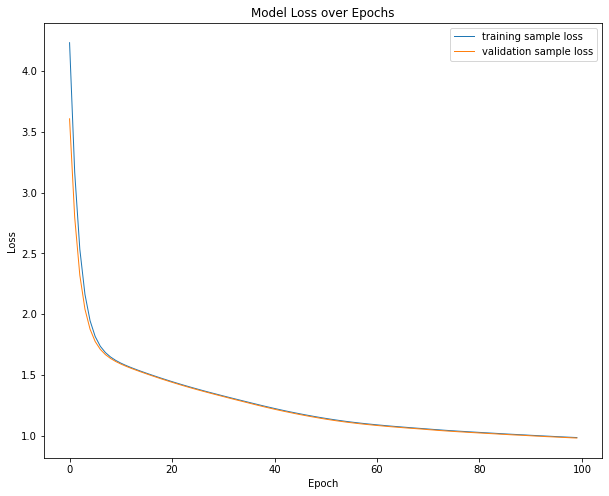

In [12]:
learningCurve(history)

In [13]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'CONV1D ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

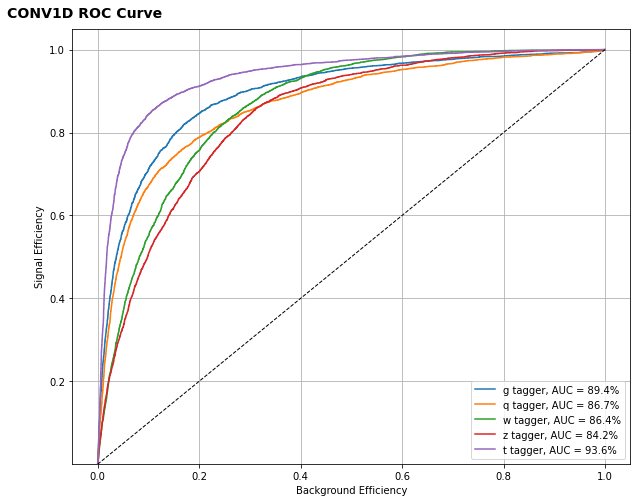

In [14]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='Conv1D')